# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 5 #minutes

config = {
    'function_family': {
        'maximum_depth': 5,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 9, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'function_generation_type': 'random_decision_tree_trained',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets10000_var9_class2_random_decision_tree_trained_xMax1_xMin0_xDistuniform_depth5_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets10000_var9_class2_random_decision_tree_trained_xMax1_xMin0_xDistuniform_depth5_beta1_decisionSpars1_vanilla_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)

## Data Inspection

In [10]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,split15,split16,split17,split18,split19,split20,split21,split22,split23,split24,split25,split26,split27,split28,split29,split30,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15,lp16,lp17,lp18,lp19,lp20,lp21,lp22,lp23,lp24,lp25,lp26,lp27,lp28,lp29,lp30,lp31
0,0.971,0.195,0.321,0.180,0.355,0.861,0.772,0.187,0.035,0.619,0.005,0.129,-1.000,0.527,0.810,0.910,-1.000,0.598,0.075,0.612,0.725,0.892,0.103,-1.000,0.075,-1.000,-1.000,0.696,1.000,-1.000,0.857,3.000,1.000,4.000,2.000,4.000,0.000,4.000,1.000,8.000,7.000,7.000,0.000,-1.000,8.000,4.000,7.000,-1.000,6.000,8.000,7.000,6.000,3.000,7.000,-1.000,4.000,-1.000,-1.000,6.000,3.000,-1.000,4.000,0.695,0.222,0.000,0.000,0.071,0.500,0.795,0.509,0.554,1.000,0.505,0.373,0.923,0.000,0.385,0.474,1.000,1.000,0.800,0.303,1.000,1.000,1.000,1.000,0.522,1.000,0.939,0.000,0.000,0.000,1.000,0.500
1,0.099,0.393,0.757,0.453,0.972,0.102,0.223,0.133,0.254,0.022,0.759,0.787,0.313,0.927,0.244,-1.000,0.865,0.070,0.303,0.790,0.492,-1.000,0.066,0.668,0.072,0.401,0.323,0.984,0.030,0.062,0.265,4.000,2.000,0.000,5.000,2.000,5.000,3.000,3.000,3.000,8.000,1.000,3.000,5.000,8.000,3.000,-1.000,7.000,3.000,0.000,6.000,2.000,-1.000,4.000,6.000,1.000,6.000,5.000,5.000,3.000,5.000,3.000,1.000,1.000,0.507,1.000,0.667,0.095,0.222,0.525,1.000,0.000,0.226,0.384,1.000,1.000,0.000,1.000,0.540,0.740,1.000,0.338,0.488,0.375,0.711,0.494,0.491,0.000,1.000,0.000,0.000,0.950,0.351,0.582
2,0.994,0.920,0.905,0.032,0.103,0.967,0.851,0.231,0.716,0.012,0.952,0.272,0.461,-1.000,-1.000,0.146,0.111,0.133,0.841,0.533,0.944,0.035,0.031,0.267,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,5.000,4.000,6.000,1.000,3.000,3.000,1.000,6.000,4.000,3.000,2.000,0.000,7.000,-1.000,-1.000,5.000,3.000,4.000,2.000,7.000,5.000,5.000,5.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,1.000,0.500,0.778,0.253,0.458,0.528,0.439,0.608,0.000,1.000,0.935,0.000,0.909,0.525,0.000,0.933,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000
3,0.576,0.965,0.793,0.859,0.032,0.782,0.935,0.291,0.140,-1.000,0.020,0.728,0.358,0.023,0.920,0.519,0.470,0.584,0.984,-1.000,-1.000,-1.000,0.137,0.516,0.269,0.532,-1.000,-1.000,0.899,0.077,0.976,3.000,7.000,2.000,1.000,5.000,2.000,2.000,6.000,4.000,-1.000,1.000,7.000,4.000,4.000,3.000,0.000,7.000,5.000,1.000,-1.000,-1.000,-1.000,1.000,1.000,2.000,7.000,-1.000,-1.000,1.000,8.000,2.000,0.592,0.464,0.493,0.419,0.963,0.611,0.550,0.281,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.648,0.467,0.555,0.677,0.541,1.000,0.000,0.000,0.000,1.000,1.000,0.641,0.444,0.200,0.579,0.000,0.625
4,0.981,0.436,0.097,0.983,0.696,0.171,0.931,0.939,0.784,0.394,0.762,-1.000,0.872,0.882,0.731,0.930,0.066,0.012,0.374,0.034,0.929,0.979,0.297,-1.000,-1.000,-1.000,-1.000,0.454,0.305,-1.000,-1.000,4.000,8.000,0.000,3.000,8.000,5.000,8.000,6.000,2.000,1.000,8.000,-1.000,6.000,0.000,3.000,6.000,3.000,7.000,7.000,1.000,5.000,7.000,3.000,-1.000,-1.000,-1.000,-1.000,3.000,3.000,-1.000,-1.000,0.478,0.857,1.000,0.315,1.000,0.000,1.000,0.000,0.364,0.611,0.527,0.333,0.401,1.000,0.581,0.496,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,0.966,0.704,0.000,0.600,0.000,0.000,1.000,1.000


In [11]:
X_data_list[0][0].head(10)

feat0   0.971
feat1   0.195
feat2   0.321
feat3   0.180
feat4   0.355
feat5   0.861
feat6   0.772
feat7   0.187
feat8   0.035
feat9   0.619
dtype: float64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8
0,0.375,0.951,0.732,0.599,0.156,0.156,0.058,0.866,0.601
1,0.708,0.021,0.970,0.832,0.212,0.182,0.183,0.304,0.525
2,0.432,0.291,0.612,0.139,0.292,0.366,0.456,0.785,0.200
3,0.514,0.592,0.046,0.608,0.171,0.065,0.949,0.966,0.808
4,0.305,0.098,0.684,0.440,0.122,0.495,0.034,0.909,0.259
5,0.663,0.312,0.520,0.547,0.185,0.970,0.775,0.939,0.895
6,0.598,0.922,0.088,0.196,0.045,0.325,0.389,0.271,0.829
7,0.357,0.281,0.543,0.141,0.802,0.075,0.987,0.772,0.199
8,0.006,0.815,0.707,0.729,0.771,0.074,0.358,0.116,0.863
9,0.623,0.331,0.064,0.311,0.325,0.730,0.638,0.887,0.472


In [13]:
y_data_list[0][0].head(10)

feat0   0.971
feat1   0.195
feat2   0.321
feat3   0.180
feat4   0.355
feat5   0.861
feat6   0.772
feat7   0.187
feat8   0.035
feat9   0.619
dtype: float64

In [14]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,1
4,0
5,1
6,0
7,1
8,1
9,0


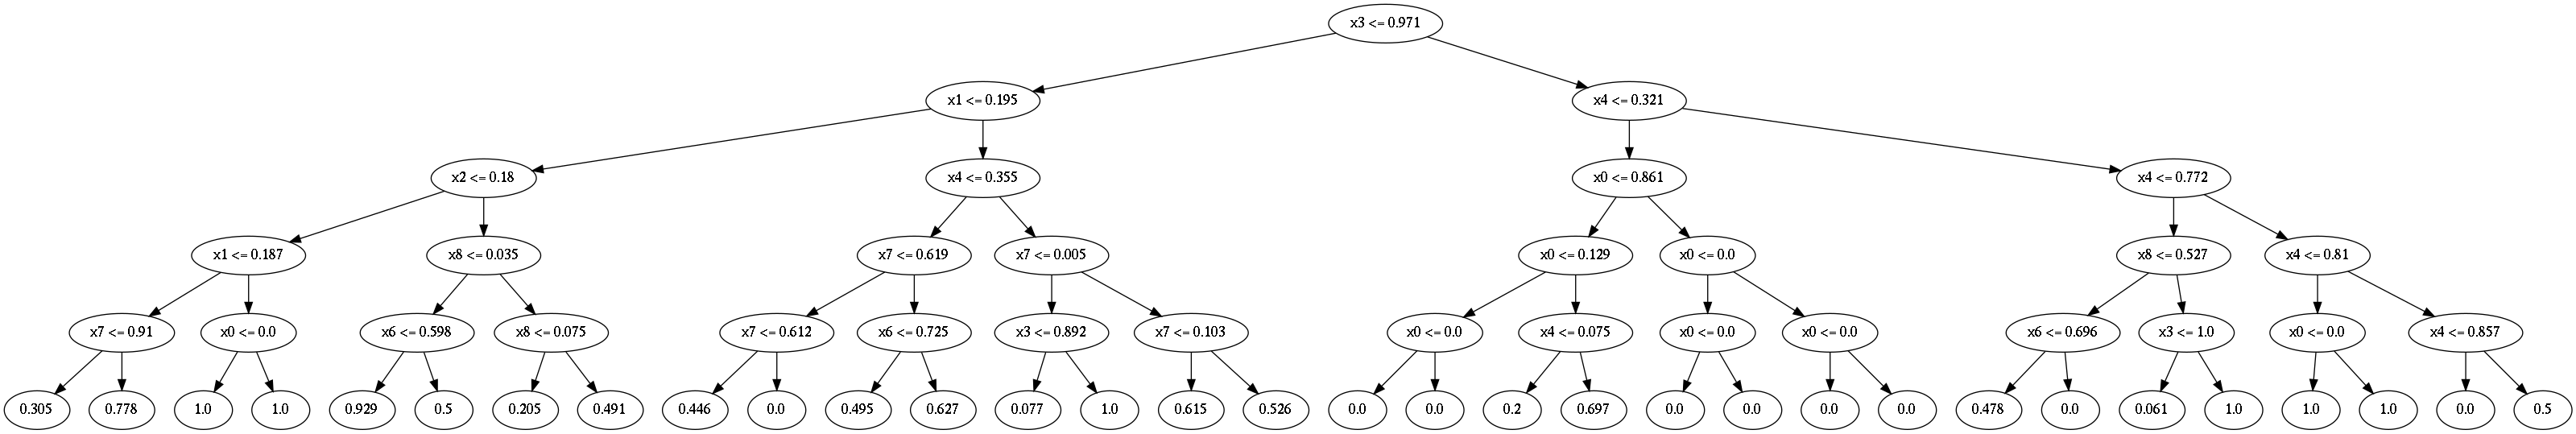

In [15]:
plot = None
if plot_tree_from_parameters != 'make_classification':
    plot = plot_tree_from_parameters(y_data_list[0][0].values, config)
plot

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        #y_data[1].reshape(-1, 1)
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

feat0   0.971
feat1   0.195
feat2   0.321
feat3   0.180
feat4   0.355
feat5   0.861
feat6   0.772
feat7   0.187
feat8   0.035
feat9   0.619
dtype: float64

In [19]:
y_data_list[0][0]

feat0   0.971
feat1   0.195
feat2   0.321
feat3   0.180
feat4   0.355
         ... 
lp27    0.000
lp28    0.000
lp29    0.000
lp30    1.000
lp31    0.500
Length: 94, dtype: float64

In [20]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,1
4,0
5,1
6,0
7,1
8,1
9,0


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

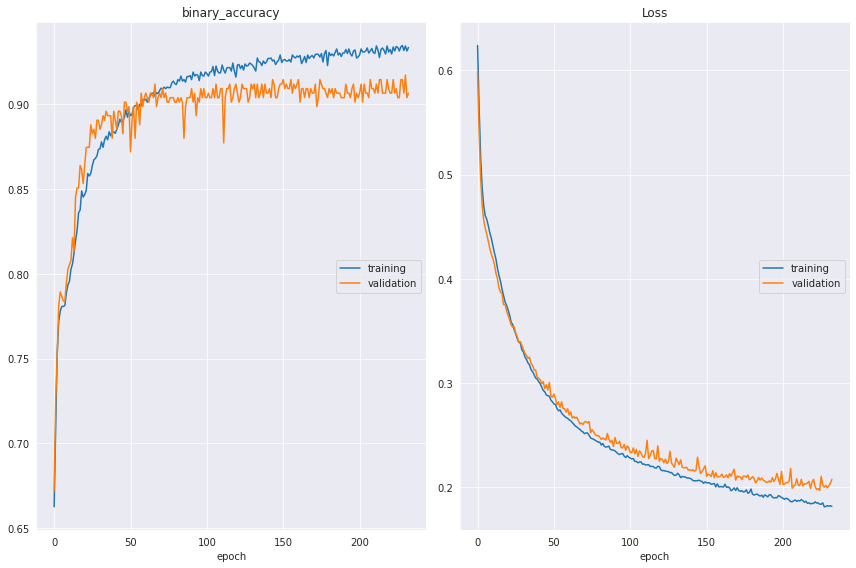

binary_accuracy
	training         	 (min:    0.663, max:    0.935, cur:    0.934)
	validation       	 (min:    0.672, max:    0.917, cur:    0.907)
Loss
	training         	 (min:    0.181, max:    0.624, cur:    0.182)
	validation       	 (min:    0.197, max:    0.599, cur:    0.207)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [ ]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list, y_data_list)))  
del parallel

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done  84 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-3)]: Done 244 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-3)]: Done 468 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-3)]: Done 756 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-3)]: Done 1108 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-3)]: Done 1524 tasks      | elapsed: 55.3min
[Parallel(n_jobs=-3)]: Done 2004 tasks      | elapsed: 72.9min
[Parallel(n_jobs=-3)]: Done 2548 tasks      | elapsed: 92.6min


In [ ]:
random_network['model'].get_config()

In [ ]:
random_network['model'].summary()

## Save and Plot Lambda-Model History

In [ ]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


In [ ]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [ ]:
loss_df.describe()

In [ ]:
val_loss_df.describe()

In [ ]:
metric_df.describe()

In [ ]:
val_metric_df.describe()

In [ ]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [ ]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [ ]:
print('a')